# **S12 T01: Aprenentatge Supervisat - Regressions**

In [1]:
# Imoporting packages
# ==============================================================================
import pandas as pd 
import datetime as dt
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
import math

from sklearn import preprocessing as prp
from sklearn import model_selection as ms
from sklearn import linear_model as lin_mod
from sklearn import dummy
from sklearn import ensemble
from sklearn import tree
from sklearn import metrics
#import sklearn.pipeline as pipeline 

from lazypredict.Supervised import LazyRegressor

# Pandas Configuration
# ==============================================================================
pd.set_option('float_format', '{:.2f}'.format) # float numbers with 2 decimals
pd.set_option("display.max_columns", None) # Display all columns

# Seaborn configuration
# ==============================================================================
sns.set_theme(style='darkgrid', palette='deep')
dims = (20, 16)

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)




## **Nivell 1**

- Exercici 1

Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

## **Imporing the Data and early analisis**

Import the dataset "Flights_Ready.csv". This dataset is the ready to use version of the dataset "DelayedFlights.cvs" as it has been previously analized and transformed to use in this project.  
You can see the transformations applied in [This notebook]()

In [2]:
flights_ready = pd.read_csv('../db/Flights/Flights_Ready.csv', index_col=0)
flights_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928371 entries, 0 to 7009727
Data columns (total 25 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Month              int64 
 1   DayofMonth         int64 
 2   DayOfWeek          int64 
 3   DepTime            int64 
 4   CRSDepTime         int64 
 5   ArrTime            int64 
 6   CRSArrTime         int64 
 7   UniqueCarrier      object
 8   FlightNum          int64 
 9   TailNum            object
 10  ActualElapsedTime  int64 
 11  CRSElapsedTime     int64 
 12  AirTime            int64 
 13  ArrDelay           int64 
 14  DepDelay           int64 
 15  Origin             object
 16  Dest               object
 17  Distance           int64 
 18  TaxiIn             int64 
 19  TaxiOut            int64 
 20  CarrierDelay       int64 
 21  WeatherDelay       int64 
 22  NASDelay           int64 
 23  SecurityDelay      int64 
 24  LateAircraftDelay  int64 
dtypes: int64(21), object(4)
memory usage: 382.5+ 

In [3]:
# Drop TailNum and FlightsMum as they dont add much value
# ============================================================================
flights_ready.drop(axis=1, columns=['TailNum', 'FlightNum'], inplace=True)

# Encoding the rest of the categorical attributes
# ============================================================================
encoder = prp.OrdinalEncoder()
flights_ready[['UniqueCarrier', 'Origin', 'Dest']]= encoder.fit_transform(flights_ready[['UniqueCarrier', 'Origin', 'Dest']])
flights_ready.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003,1955,2211,2225,17.00,128,150,116,-14,8,135.00,284.00,810,4,8,0,0,0,0,0
1,1,3,4,754,735,1002,1000,17.00,128,145,113,2,19,135.00,284.00,810,5,10,0,0,0,0,0
2,1,3,4,628,620,804,750,17.00,96,90,76,14,8,140.00,48.00,515,3,17,0,0,0,0,0
4,1,3,4,1829,1755,1959,1925,17.00,90,90,77,34,34,140.00,48.00,515,3,10,2,0,0,0,32
5,1,3,4,1940,1915,2121,2110,17.00,101,115,87,11,25,140.00,149.00,688,4,10,0,0,0,0,0


## **Making a random sample containing 0.3% of the Dataset**

In [4]:
flights_sample = flights_ready.sample(frac=0.003,  random_state = 42)
flights_sample.shape

(5785, 23)

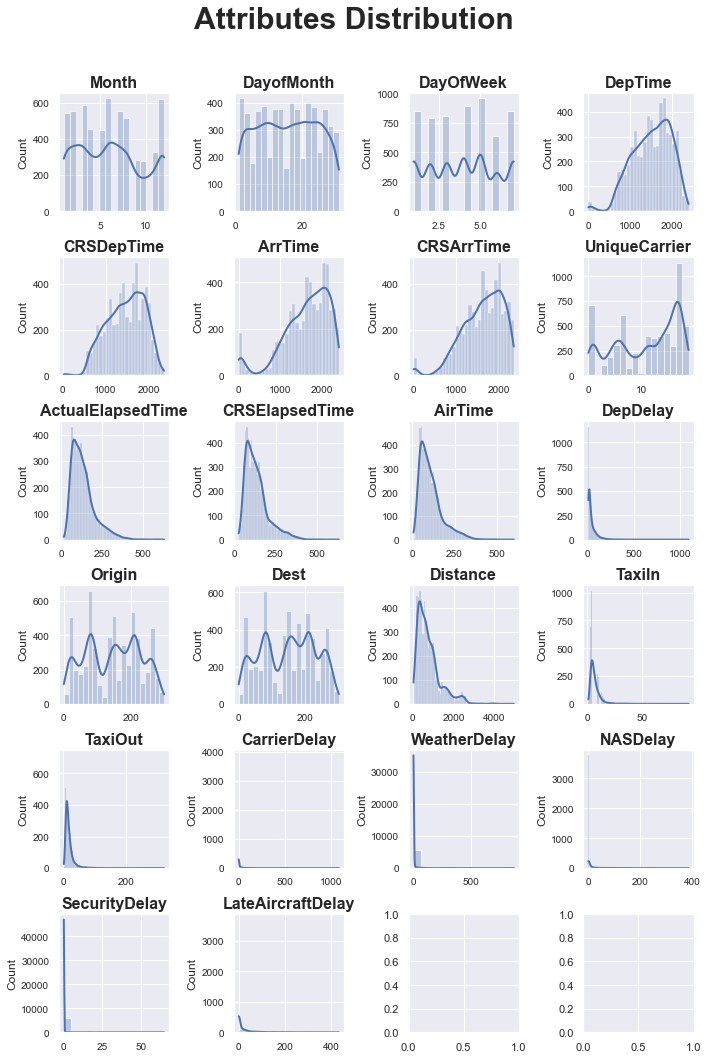

In [5]:
# Distribution graph for each attribute
# ==============================================================================

graphs = flights_sample.copy().drop(axis=1, columns=['ArrDelay'])
fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(10, 15))
axes = axes.flat
for i, colum in enumerate(graphs):
    sns.histplot( data=graphs,x= colum, stat="count",kde= True, line_kws={'linewidth': 2},alpha= 0.3,ax= axes[i])
    axes[i].set_title(colum, fontsize = 16, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Attributes Distribution', fontsize = 30, fontweight = "bold")
plt.show()

del graphs

## **Split the dataset into training/test**

In [6]:
X = flights_sample.drop('ArrDelay', axis=1)
y = flights_sample['ArrDelay']

X_train, X_test, y_train, y_test = ms.train_test_split(X,y, test_size = 0.25, random_state=42)

print(f"Train X:{X_train.shape}, Train y:{y_train.shape}\nTest X:{X_test.shape}, {y_test.shape}")

Train X:(4338, 22), Train y:(4338,)
Test X:(1447, 22), (1447,)


## **Appling Regression Models to the dataset**

In [7]:
# Lazy Regressor
# ============================================================================
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, prediction = reg.fit(X_train, X_test, y_train, y_test)
lazy_df = pd.DataFrame(models)

 21%|██▏       | 9/42 [00:03<00:14,  2.31it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 79%|███████▊  | 33/42 [00:16<00:03,  2.58it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


100%|██████████| 42/42 [00:22<00:00,  1.91it/s]


[(-0.5, 1.0)]

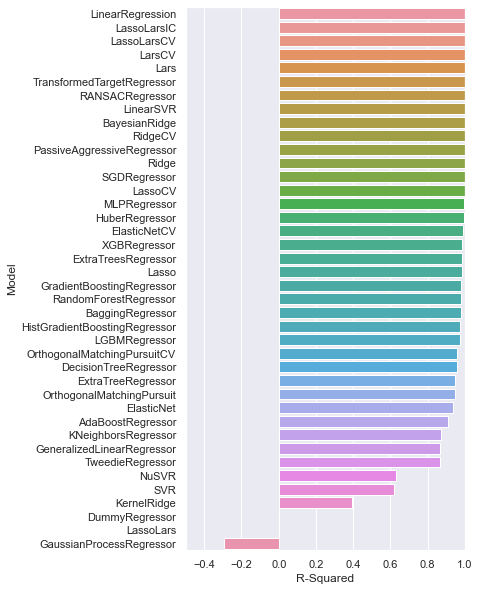

In [8]:
# Display  Predictions Graph with LazzyRegressor
# ============================================================================
# Using this early classification we can choose the different methods depending on his performance

plt.figure(figsize=(5, 10))
ax = sns.barplot(y=lazy_df.index, x="R-Squared", data=lazy_df)
ax.set(xlim=(-0.5, 1))

From the early analisis provided by the Lazy Regressor we choose three models (top, middle and bottom) based on their Accuracy:  
    - Linear Regression (Top)  
    - Random Forest Regressor (Bottom)
    - LASSO Regression (Middle)

In [9]:
# Dummy Regressor
# ============================================================================
dummy_reg = dummy.DummyRegressor()
dummy_reg.fit(X_train, y_train)

# linear Regression
# ============================================================================
lin_reg = lin_mod.LinearRegression(n_jobs=3)
lin_reg.fit(X_train, y_train)


# Random Forest Regressor
# ============================================================================
rand_forest = ensemble.RandomForestRegressor(random_state=42, n_jobs=3)
rand_forest.fit(X_train,y_train)

# LASSO Regression
# ============================================================================
lasso = lin_mod.Lasso(random_state=42)
lasso.fit(X_train,y_train)

Lasso(random_state=42)

### <u>Linear Regression:<u>

- Exercici 2

Compara’ls en base al MSE i al R2 .


In [10]:
# Seeing the results of Lazy Regressor
# =======================================================
lazy_df.sort_values(["R-Squared", "Time Taken"], ascending=[False, True])
lazy_df

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LinearRegression,1.00,1.00,0.00,0.02
LassoLarsIC,1.00,1.00,0.00,0.02
LassoLarsCV,1.00,1.00,0.00,0.06
LarsCV,1.00,1.00,0.00,0.05
Lars,1.00,1.00,0.00,0.02
TransformedTargetRegressor,1.00,1.00,0.00,0.02
RANSACRegressor,1.00,1.00,0.00,0.02
LinearSVR,1.00,1.00,0.00,0.12
BayesianRidge,1.00,1.00,0.01,0.06


In [11]:
model_names =['Dummy', 'Lin Reg', 'Rand Forest', 'LASSO']

def ModelEvaluator(model_list, X_test, y_test, model_names):
    models = model_list
    scores_dict={}
    for model, name in zip(models, model_names):
        scores = {'MSE':metrics.mean_squared_error(y_test, model.predict(X_test)),
                'RMSE':math.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test))),
                'MAE':metrics.mean_absolute_error(y_test, model.predict(X_test)),
                'R2_Score':metrics.r2_score(y_test, model.predict(X_test))}
        scores_dict[name] = scores
        scores_df = pd.DataFrame.from_dict(scores_dict).transpose()

    return scores_df

In [12]:
model_list=[dummy_reg, lin_reg, rand_forest, lasso]
pd.set_option('float_format', '{:.4f}'.format) # float numbers with 4 decimals
raw_models = ModelEvaluator(model_list, X_test, y_test, model_names )
raw_models

,MSE,RMSE,MAE,R2_Score
Dummy,2890.3647,53.7621,36.7891,-0.0003
Lin Reg,0.0000,0.0000,0.0000,1.0000
Rand Forest,58.9589,7.6785,4.3434,0.9796
LASSO,0.0436,0.2088,0.1451,1.0000


[]

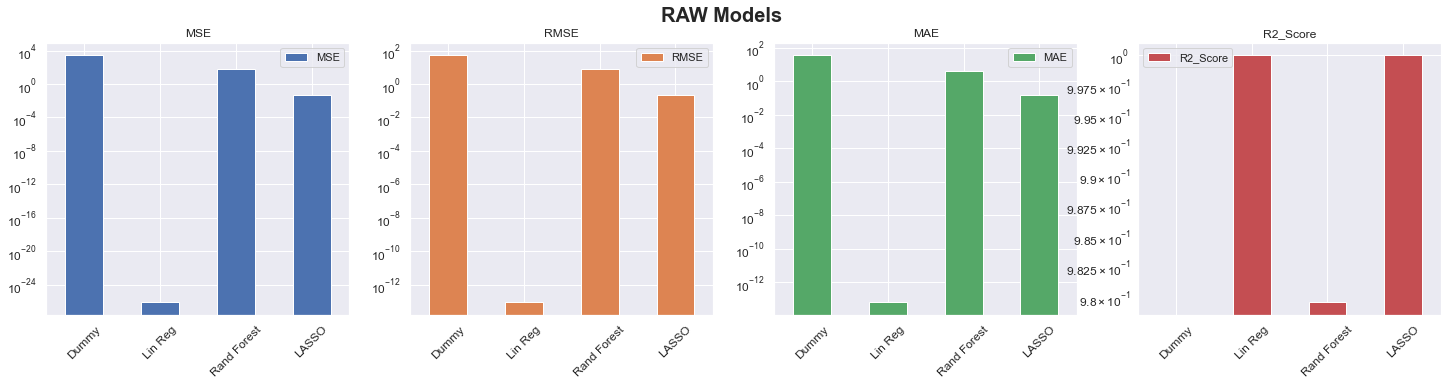

In [13]:
fig, ax = plt.subplots(figsize=(25,5))
raw_models.plot(kind='bar', subplots=True, layout=(1,4), logy=True, figsize=(25,5), rot=45, fontsize=12, ax=ax)
fig.suptitle('RAW Models', fontsize=20, weight='bold')
plt.plot()

- Exercici 3

Entrena’ls utilitzant els diferents paràmetres que admeten.

This excersize will be performedu usin [Ranomized Search CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) method. This algorithm find the optimal parameters performing Cross Validation tests with the different values you set for each parameter.

##  **Defining the testing function**

In [14]:
def rand_search_eval(model_names, distribution):
    rscv = ms.RandomizedSearchCV(model_names, distribution, n_iter=10, n_jobs=3, cv=5, random_state=42, return_train_score=False, refit=True)
    rscv_search = rscv.fit(X_train,y_train)
    rscv_statistics = {
        'Best Score': rscv_search.best_score_,
        'Best Parameters':rscv_search.best_params_}
    rscv_results = pd.DataFrame(rscv_search.cv_results_)
    return (rscv_statistics, rscv_results)

## **Defining the attributes for each Regressor**

In [15]:
distributions= {
    'Dummy': dict(strategy=['mean', 'median']),
    'Linear Reg': dict(fit_intercept=[True, False], normalize=[True,False]),
    'Rand Forest': dict(n_estimators=[10, 25, 100], criterion=["mse", "mae"], max_depth=[25, 50, None], bootstrap=[True, False]),
    'LASSO': dict(alpha=[1,0.5,0.25], fit_intercept=[True,False], normalize=[True, False],max_iter=[100, 500, 1000], warm_start=[True, False])
}

## **Appliing the algorithm to Regressors and obtaining the best parameters**

In [16]:
dummy_RSCV_statistics, dummy_RSCV_results = rand_search_eval(dummy_reg, distributions['Dummy'])
lin_reg_RSCV_statistics, lin_reg_RSCV_results = rand_search_eval(lin_reg, distributions['Linear Reg'])
rand_forest_RSCV_statistics, rand_forest_RSCV_results = rand_search_eval(rand_forest, distributions['Rand Forest'])
lasso_RSCV_statistics, lasso_RSCV_results = rand_search_eval(lasso, distributions['LASSO'])  

In [17]:
statistics_list = [dummy_RSCV_statistics,lin_reg_RSCV_statistics, rand_forest_RSCV_statistics, lasso_RSCV_statistics]
for name, statistics in zip(model_names, statistics_list): 
    print(name)
    print(statistics)
    print

Dummy
{'Best Score': -0.0024812308195700794, 'Best Parameters': {'strategy': 'mean'}}
Lin Reg
{'Best Score': 1.0, 'Best Parameters': {'normalize': True, 'fit_intercept': True}}
Rand Forest
{'Best Score': 0.92808205401101, 'Best Parameters': {'n_estimators': 100, 'max_depth': None, 'criterion': 'mse', 'bootstrap': True}}
LASSO
{'Best Score': 0.9999940014083956, 'Best Parameters': {'warm_start': True, 'normalize': False, 'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.5}}


## **Setting the new models with the optimized parameters**

In [18]:
# Dummy Regressor
# ============================================================================
dummy_reg_opt = dummy.DummyRegressor(strategy= 'mean')
dummy_reg_opt.fit(X_train, y_train)

# linear Regression
# ============================================================================
lin_reg_opt = lin_mod.LinearRegression(normalize=True, fit_intercept= True, n_jobs=3)
lin_reg_opt.fit(X_train, y_train)


# Random Forest Regressor
# ============================================================================
rand_forest_opt = ensemble.RandomForestRegressor(n_estimators=100, max_depth= None, criterion='mse', bootstrap=True, random_state=42, n_jobs=3)
rand_forest_opt.fit(X_train,y_train)

# LASSO Regression
# ============================================================================
lasso_opt = lin_mod.Lasso(warm_start=True, normalize=False, max_iter= 1000, fit_intercept=True, alpha=0.5, random_state=42)
lasso_opt.fit(X_train,y_train)

Lasso(alpha=0.5, random_state=42, warm_start=True)

In [19]:
opt_models = ModelEvaluator([dummy_reg_opt, lin_reg_opt, rand_forest_opt, lasso_opt], X_test, y_test, model_names)
opt_models

,MSE,RMSE,MAE,R2_Score
Dummy,2890.3647,53.7621,36.7891,-0.0003
Lin Reg,0.0000,0.0000,0.0000,1.0000
Rand Forest,58.9589,7.6785,4.3434,0.9796
LASSO,0.0147,0.1213,0.0849,1.0000


[]

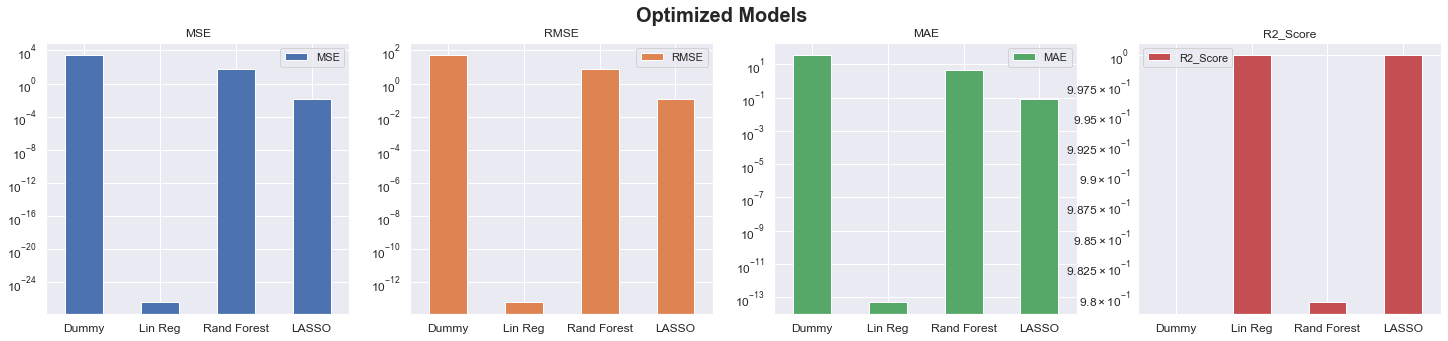

In [20]:
fig, ax = plt.subplots(figsize=(25,5))
opt_models.plot(kind='bar', subplots=True, layout=(1,4), logy=True, figsize=(25,5), rot=0, fontsize=12, ax=ax)
fig.suptitle('Optimized Models', fontsize=20, weight='bold')
plt.plot()

- Exercici 4

Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)

In [21]:
opt_model_list = [dummy_reg_opt, lin_reg_opt, rand_forest_opt, lasso_opt]

predicted_cv = {}
scores_dict={}
for model, name in zip(opt_model_list, model_names): 
    y_pred_cv = ms.cross_val_predict(model, X, y, cv=10, n_jobs=3)
    predicted_cv[name] = y_pred_cv
    scores = {'MSE':metrics.mean_squared_error(y_test, model.predict(X_test)),
                'RMSE':math.sqrt(metrics.mean_squared_error(y, y_pred_cv)),
                'MAE':metrics.mean_absolute_error(y, y_pred_cv),
                'R2_Score':metrics.r2_score(y, y_pred_cv)        
    }
    scores_dict[name] = scores
cv_models = pd.DataFrame.from_dict(scores_dict).transpose()
cv_models

,MSE,RMSE,MAE,R2_Score
Dummy,2890.3647,55.9960,36.8937,-0.0008
Lin Reg,0.0000,0.0000,0.0000,1.0000
Rand Forest,58.9589,11.3248,4.4215,0.9591
LASSO,0.0147,0.1367,0.0917,1.0000


[]

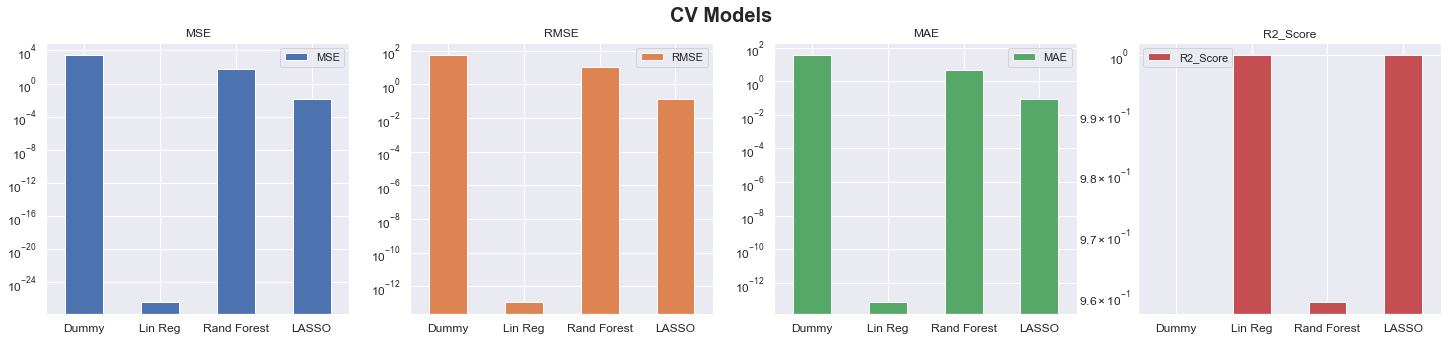

In [22]:
fig, ax = plt.subplots(figsize=(25,5))
cv_models.plot(kind='bar', subplots=True, layout=(1,4), figsize=(25,5), logy=True, rot=0, fontsize=12, ax=ax)
fig.suptitle('CV Models', fontsize=20, weight='bold')
plt.plot()

In [23]:
resume = pd.concat([raw_models, opt_models, cv_models], axis=0, keys=['RAW', 'OPT', 'CV']).reorder_levels(order=[1,0])
resume.sort_index()

MSE    RMSE     MAE  R2_Score
Dummy       CV  2890.3647 55.9960 36.8937   -0.0008
            OPT 2890.3647 53.7621 36.7891   -0.0003
            RAW 2890.3647 53.7621 36.7891   -0.0003
LASSO       CV     0.0147  0.1367  0.0917    1.0000
            OPT    0.0147  0.1213  0.0849    1.0000
            RAW    0.0436  0.2088  0.1451    1.0000
Lin Reg     CV     0.0000  0.0000  0.0000    1.0000
            OPT    0.0000  0.0000  0.0000    1.0000
            RAW    0.0000  0.0000  0.0000    1.0000
Rand Forest CV    58.9589 11.3248  4.4215    0.9591
            OPT   58.9589  7.6785  4.3434    0.9796
            RAW   58.9589  7.6785  4.3434    0.9796

array([[<AxesSubplot:title={'center':'(Dummy, CV)'}>,
        <AxesSubplot:title={'center':'(Dummy, OPT)'}>,
        <AxesSubplot:title={'center':'(Dummy, RAW)'}>],
       [<AxesSubplot:title={'center':'(LASSO, CV)'}>,
        <AxesSubplot:title={'center':'(LASSO, OPT)'}>,
        <AxesSubplot:title={'center':'(LASSO, RAW)'}>],
       [<AxesSubplot:title={'center':'(Lin Reg, CV)'}>,
        <AxesSubplot:title={'center':'(Lin Reg, OPT)'}>,
        <AxesSubplot:title={'center':'(Lin Reg, RAW)'}>],
       [<AxesSubplot:title={'center':'(Rand Forest, CV)'}>,
        <AxesSubplot:title={'center':'(Rand Forest, OPT)'}>,
        <AxesSubplot:title={'center':'(Rand Forest, RAW)'}>]],
      dtype=object)

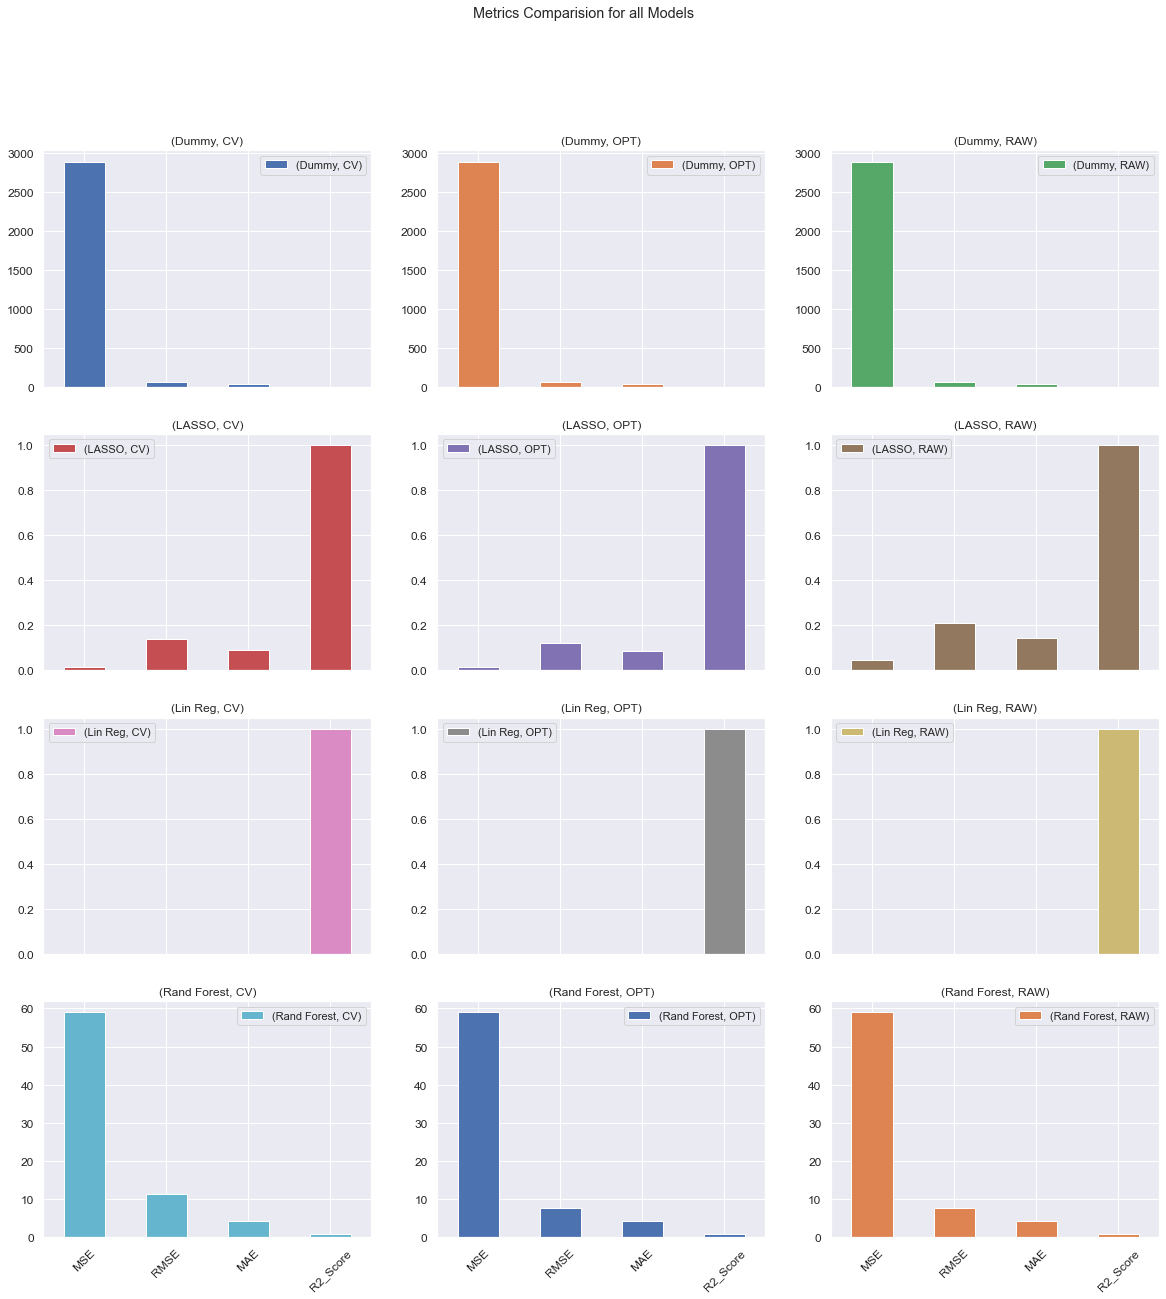

In [24]:
resume_t = resume.transpose()
resume_t = resume_t.sort_index(1, level=0, sort_remaining=True)
resume_t.plot(kind='bar', figsize=(20,20), subplots=True, layout=(4,3), rot=45, fontsize=12, title='Metrics Comparision for all Models')

## **Nivell 2**



- Exercici 5

Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

## **Scaling Attributes**

In [25]:
# Standarizing attributes with StandardScaler. 
# ==========================================================================================

scaler = prp.RobustScaler()
flights_sample_scaled = scaler.fit_transform(flights_sample)
print(scaler.get_params())

flights_sample_scaled = pd.DataFrame(flights_sample_scaled, columns=flights_sample.columns, index=flights_sample.index)
flights_sample_scaled.describe()

{'copy': True, 'quantile_range': (25.0, 75.0), 'with_centering': True, 'with_scaling': True}


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000,5785.0000
mean,0.0243,-0.0214,-0.0068,-0.0413,-0.0657,-0.1446,-0.1121,-0.1718,0.1899,0.1854,0.2119,0.3651,0.4384,-0.0682,-0.0462,0.2358,0.2262,0.3759,1.2746,2.5846,1.6502,0.0605,0.8438
std,0.5791,0.5860,0.4963,0.6509,0.6238,0.7552,0.6727,0.5377,0.8612,0.8477,0.8662,1.1910,1.2798,0.6197,0.6172,0.8758,1.2492,1.2628,3.5656,22.0873,4.6315,1.2868,1.8329
min,-0.8333,-1.0000,-0.7500,-2.2209,-2.1679,-2.3870,-2.4519,-1.1818,-1.2317,-1.1205,-1.0769,-1.4043,-0.4634,-1.1923,-1.1923,-0.9011,-1.2500,-1.0909,0.0000,0.0000,0.0000,0.0000,0.0000
25%,-0.5000,-0.5333,-0.5000,-0.4921,-0.5474,-0.5659,-0.5624,-0.6364,-0.4512,-0.4458,-0.4231,-0.3404,-0.3171,-0.5769,-0.5769,-0.4158,-0.5000,-0.3636,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.5000,0.4667,0.5000,0.5079,0.4526,0.4341,0.4376,0.3636,0.5488,0.5542,0.5769,0.6596,0.6829,0.4231,0.4231,0.5842,0.5000,0.6364,1.0000,0.0000,1.0000,0.0000,1.0000
max,1.0000,1.0000,0.7500,1.2209,1.2321,0.9404,0.9311,0.5455,6.1951,6.2169,6.4872,23.4894,25.9756,1.1154,1.1231,6.7202,21.7500,27.7273,121.1111,876.0000,64.1667,65.0000,21.6500


## **Train/Test Split for the Scaled DF**

In [26]:
X = flights_sample_scaled.drop('ArrDelay', axis=1)
y = flights_sample_scaled['ArrDelay']

X_train, X_test, y_train, y_test = ms.train_test_split(X,y, test_size = 0.25, random_state=42)

print(f"Train X:{X_train.shape}, Train y:{y_train.shape}\nTest X:{X_test.shape}, {y_test.shape}")

Train X:(4338, 22), Train y:(4338,)
Test X:(1447, 22), (1447,)


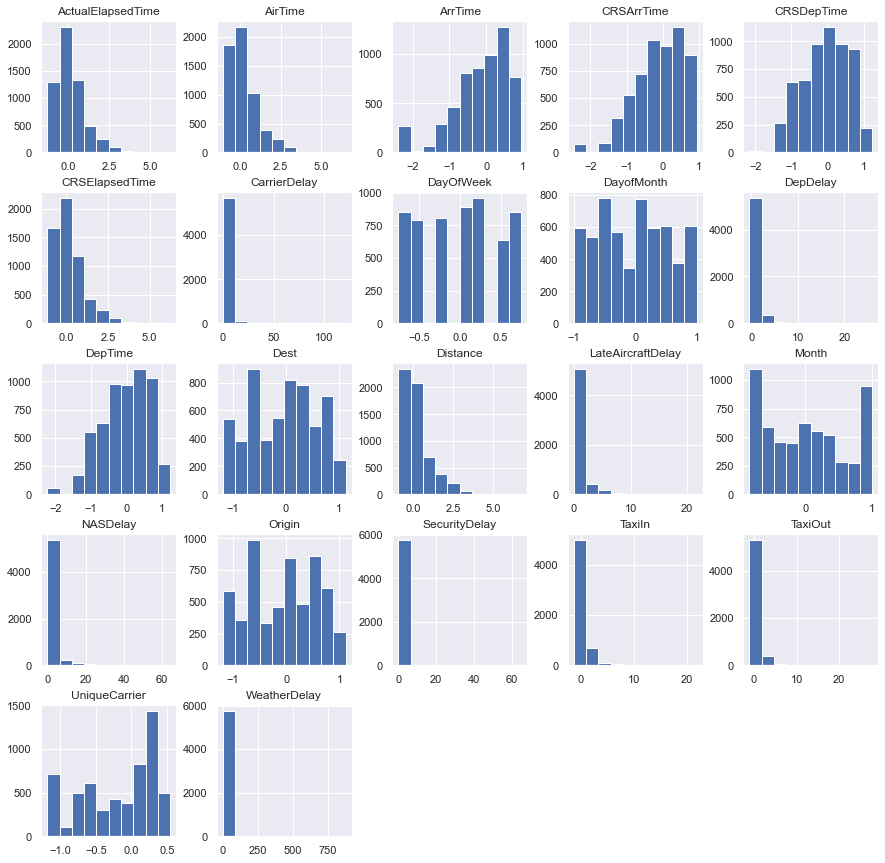

In [27]:
# Distributions of the scaled attributes
# ====================================================
X.hist(figsize=(15,15))
plt.show()

## **Analizing LASSO coffiicients for variable selection**

LASSO regression uses L1 regularization. This regularization results that some coeficients become nearly 0 when we have a heavy correlation between our attributes (multicolinearity). Hence, this algorithm acts as a dimensional reducition algorithm too.  

In [28]:
params = lasso_opt.get_params()
r_sq = lasso_opt.score(X_train, y_train)
lasso_coef= lasso_opt.coef_
lasso_coef = np.append(lasso_coef, values=[r_sq, lasso_opt.intercept_])
columns = np.append(X.columns, values=['R^2', 'Intercept'] )
lasso_coef = pd.DataFrame(lasso_coef, index=columns, columns=['Cofeficient'])
lasso_coef


,Cofeficient
Month,-0.0000
DayofMonth,-0.0000
DayOfWeek,-0.0000
DepTime,0.0000
CRSDepTime,-0.0000
ArrTime,0.0000
CRSArrTime,0.0000
UniqueCarrier,-0.0000
ActualElapsedTime,0.2405
CRSElapsedTime,-0.9874


In [29]:
# Show the attributes who actually have meaning for the regression
# =================================================================================

high_coef = lasso_coef[(lasso_coef >= 0.001) | (lasso_coef<=-0.001)].dropna()
high_coef

,Cofeficient
ActualElapsedTime,0.2405
CRSElapsedTime,-0.9874
AirTime,0.7465
DepDelay,0.9915
TaxiIn,0.7296
TaxiOut,0.7476
CarrierDelay,0.0081
WeatherDelay,0.0080
NASDelay,0.0095
LateAircraftDelay,0.0081


## **Dropping the low coef index for dimmensional Reduction**

In [30]:
X_train = X_train[high_coef.drop(['R^2', 'Intercept'], axis=0).index]
X_test = X_test[high_coef.drop(['R^2', 'Intercept'], axis=0).index]

print(f"Train X:{X_train.shape}, Train y:{y_train.shape}\nTest X:{X_test.shape}, {y_test.shape}")

Train X:(4338, 10), Train y:(4338,)
Test X:(1447, 10), (1447,)


## **Generating the models**

In [31]:
# Dummy Regressor
# ============================================================================
dummy_reg_hc = dummy.DummyRegressor(strategy= 'mean')
dummy_reg_hc.fit(X_train, y_train)

# linear Regression
# ============================================================================
lin_reg_hc = lin_mod.LinearRegression(normalize=True, fit_intercept= True, n_jobs=3)
lin_reg_hc.fit(X_train, y_train)


# Random Forest Regressor
# ============================================================================
rand_forest_hc = ensemble.RandomForestRegressor(n_estimators=100, max_depth= None, criterion='mse', bootstrap=True, random_state=42, n_jobs=3)
rand_forest_hc.fit(X_train,y_train)

# LASSO Regression
# ============================================================================
lasso_hc = lin_mod.Lasso(warm_start=True, normalize=False, max_iter= 1000, fit_intercept=True, alpha=0.5, random_state=42)
lasso_hc.fit(X_train,y_train)

Lasso(alpha=0.5, random_state=42, warm_start=True)

## **Predicting the values and obtaining metrics**

In [32]:
hc_models = ModelEvaluator([dummy_reg_hc, lin_reg_hc, rand_forest_hc, lasso_hc], X_test, y_test, model_names)
hc_models

,MSE,RMSE,MAE,R2_Score
Dummy,1.3084,1.1439,0.7827,-0.0003
Lin Reg,0.0000,0.0000,0.0000,1.0000
Rand Forest,0.0226,0.1505,0.0807,0.9827
LASSO,0.1419,0.3767,0.2369,0.8915


[]

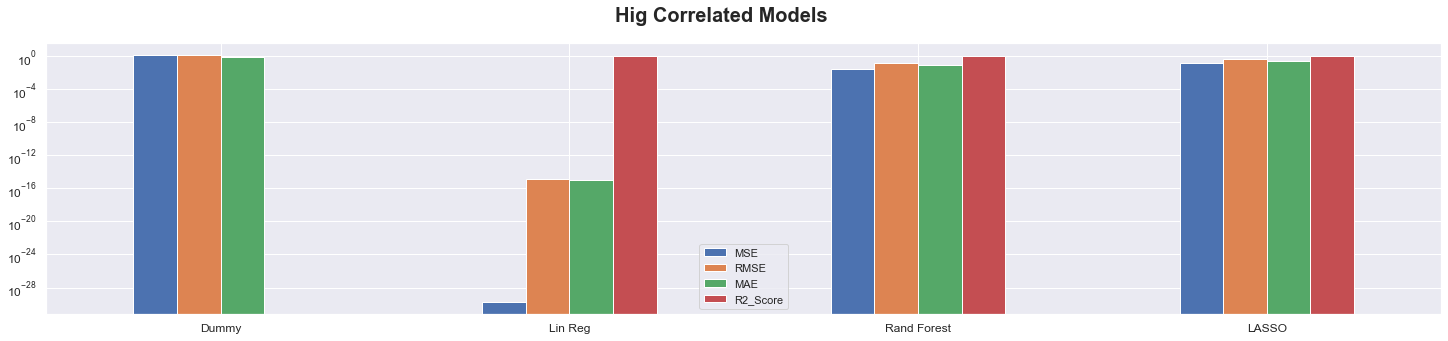

In [33]:
fig, ax = plt.subplots()
hc_models.plot(kind='bar', subplots=False, layout=(1,6), figsize=(25,5), logy=True, rot=0, fontsize=12, ax=ax)
fig.suptitle('Hig Correlated Models', fontsize=20, weight='bold'),
plt.plot()

## **Nivell 4**


- Exercici 6

No utilitzis la variable **DepDelay** a l’hora de fer prediccions

As it can be seen on the correlation matrix and in attributes weight on linnear and LASSO Regresions, the DepDelay Attribue is higlly correlated to the ArrDelay(target) attribute. This is logic as a Departure delay means that the plane will accumulate this delay to the target attribute. For example if a plane departures with 2h DepDelay we can easily deduce that the plane will arribe with a minimum delay arround 2h (even if it can be slighlty compensated during Air Time increasing velocity or with favorable wind currents).

This fenomenon explains the good results of our primal models. As the models are quite accurate, deleting the DepDelay Attribute will be more challenging in order to perform Feature Engineering to improve our prediction models.  

In [34]:
X_train_ndd = X_train.drop(axis=1, columns=['DepDelay'], inplace=False)
X_test_ndd = X_test.drop(axis=1, columns=['DepDelay'], inplace=False)
print(f"Train X:{X_train_ndd.shape}, Train y:{y_train.shape}\nTest X:{X_test_ndd.shape}, {y_test.shape}")

Train X:(4338, 9), Train y:(4338,)
Test X:(1447, 9), (1447,)


## **Generating the models**

In [35]:
# Dummy Regressor
# ============================================================================
dummy_reg_ndd = dummy.DummyRegressor(strategy= 'mean')
dummy_reg_ndd.fit(X_train_ndd, y_train)

# linear Regression
# ============================================================================
lin_reg_ndd = lin_mod.LinearRegression(normalize=True, fit_intercept= True, n_jobs=3)
lin_reg_ndd.fit(X_train_ndd, y_train)


# Random Forest Regressor
# ============================================================================
rand_forest_ndd = ensemble.RandomForestRegressor(n_estimators=100, max_depth= None, criterion='mse', bootstrap=True, random_state=42, n_jobs=3)
rand_forest_ndd.fit(X_train_ndd,y_train)

# LASSO Regression
# ============================================================================
lasso_ndd = lin_mod.Lasso(warm_start=True, normalize=False, max_iter= 1000, fit_intercept=True, alpha=0.5, random_state=42)
lasso_ndd.fit(X_train_ndd,y_train)

Lasso(alpha=0.5, random_state=42, warm_start=True)

## **Predicting the values and obtaining metrics**

In [36]:
ndd_models = ModelEvaluator([dummy_reg_ndd, lin_reg_ndd, rand_forest_ndd, lasso_ndd], X_test_ndd, y_test, model_names)
ndd_models

,MSE,RMSE,MAE,R2_Score
Dummy,1.3084,1.1439,0.7827,-0.0003
Lin Reg,0.0095,0.0975,0.0662,0.9927
Rand Forest,0.0294,0.1716,0.0803,0.9775
LASSO,0.1419,0.3767,0.2369,0.8915


[]

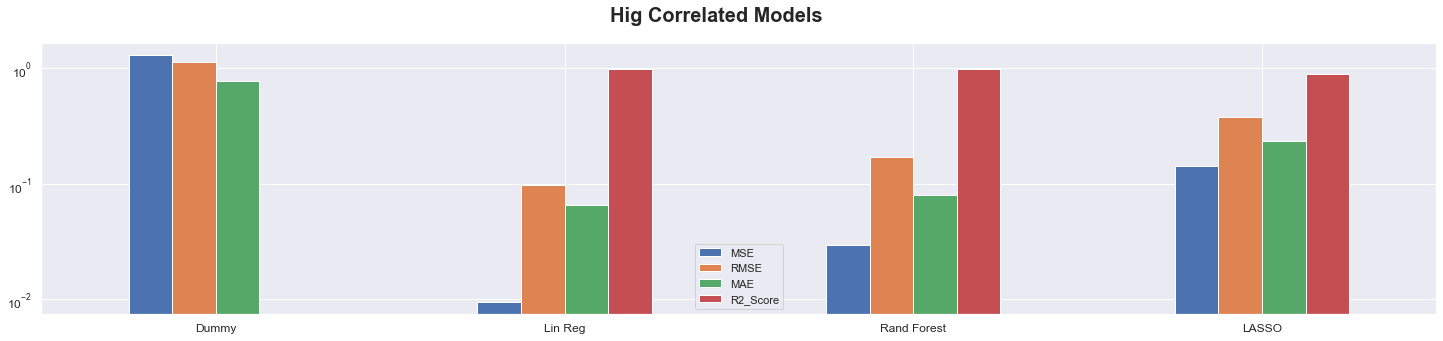

In [37]:
fig, ax = plt.subplots()
ndd_models.plot(kind='bar', subplots=False, layout=(1,6), figsize=(25,5), logy=True, rot=0, fontsize=12, ax=ax)
fig.suptitle('Hig Correlated Models', fontsize=20, weight='bold'),
plt.plot()

## **Comparing High Correlated and Hight Correlated with No delay Metrics**

In [38]:
resume = pd.concat([raw_models, ndd_models, hc_models], axis=0, keys=['RAW','No DPT Delay', 'HC Attributes']).reorder_levels(order=[1,0])
resume = resume.drop('Dummy', level=0).drop('MSE', axis=1)
resume.sort_index()

RMSE    MAE  R2_Score
LASSO       HC Attributes 0.3767 0.2369    0.8915
            No DPT Delay  0.3767 0.2369    0.8915
            RAW           0.2088 0.1451    1.0000
Lin Reg     HC Attributes 0.0000 0.0000    1.0000
            No DPT Delay  0.0975 0.0662    0.9927
            RAW           0.0000 0.0000    1.0000
Rand Forest HC Attributes 0.1505 0.0807    0.9827
            No DPT Delay  0.1716 0.0803    0.9775
            RAW           7.6785 4.3434    0.9796

<AxesSubplot:title={'center':'Metrics Comparision for all Models'}>

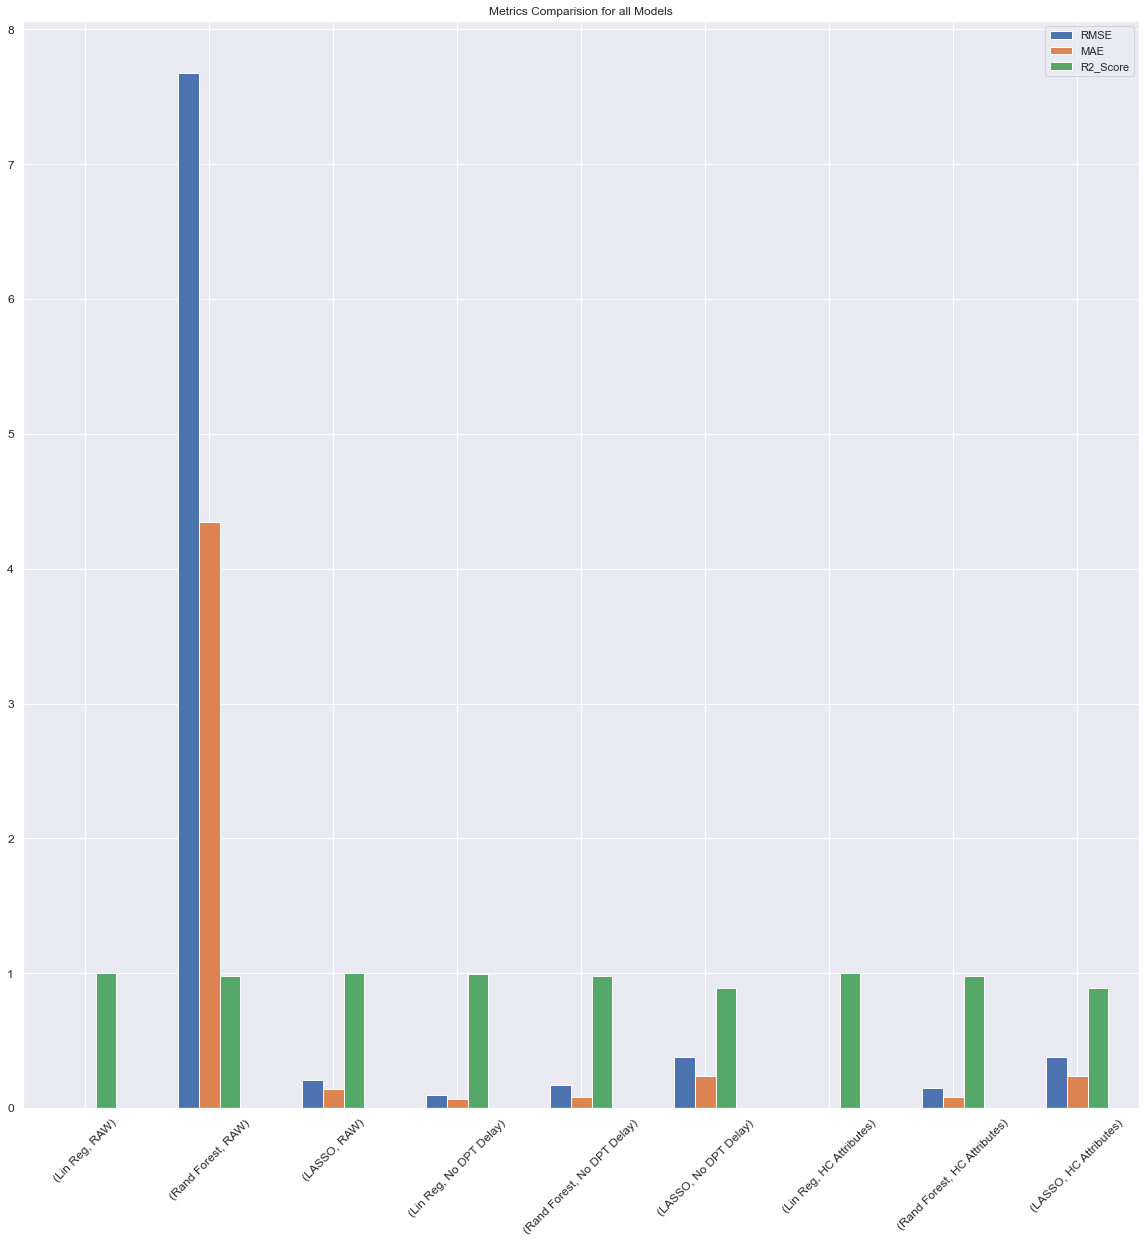

In [39]:
resume_t = resume.sort_index(1, level=0, sort_remaining=True).transpose()
resume_t

resume.plot(kind='bar', figsize=(20,20), subplots=False, layout=(3,4), rot=45, fontsize=12, title='Metrics Comparision for all Models')

Even when dropping the "Dep.Delay" Attribute ttributes the Regressors perform quite similar with a slightly low performance without "Dep.Delay".  
Comparing with the raw regressors most of the algorithms make a wors R^2 score and increase the errors, but this results are quite more realistics as the raw models tend to overfit. 

In any cases the Regressors perform quite well but the LASSO regressor sems affected after the Atribute reduction as it tends to reduce the attributes again. 